# Introduction
LSTM Basics got us to a point of understanding simple LSTM. When it comes real life scenarios the picture gets more complicated a simple 1 layer LSTM just doesnt to the job. Usually multi layer LSTM are required where each layer does a part of the job then sends the output to next layer and so on. Building a deep RNN stacking multiple recurrent hidden layers allows the hidden state at each level to operate at a different timescale.
Starting of with Stacked LSTM which has multiple hidden LSTM layers the architecture where the depth of the network mattered more the number of memory cells in a given layer, A Stacked LSTM can be defined an LSTM model comprising of multiple LSTM.
The implementation example needs to more close to real life. 
Stock market prediction are always intriguing. Technical Stock Analysis believes the complete intelligence of predicting movement of a stock is in OHLC (Open , High, Low and Close) and may be volume. 

Stock market data is time series by nature. Quandl has been the data source. Some key aspects to understand while predicting the trend or price here.Most analyst would look into moving average or exponential moving average over a certain period to define the trend. A more realistic approach would be to also include trend indicators and price indicators into the dataset. 

One Step Ahead Prediction Average
We try to predict the future stock market prices (for example, xt+1) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days)

Exponential Moving Average
calculate xt+1 as,
xt+1 = EMAt = γ × EMAt-1 + (1-γ) xt where EMA0 = 0 and EMA is the exponential moving average value we maintain over time.
The above equation basically calculates the exponential moving average from t+1 time step and uses that as the one step ahead prediction. γ decides what the contribution of the most recent prediction is to the EMA. 

For the sake of simplicity we are going to take 1 feature close and not include any averaging technique for now. 


In [89]:
#Imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import quandl
from pandas import DataFrame

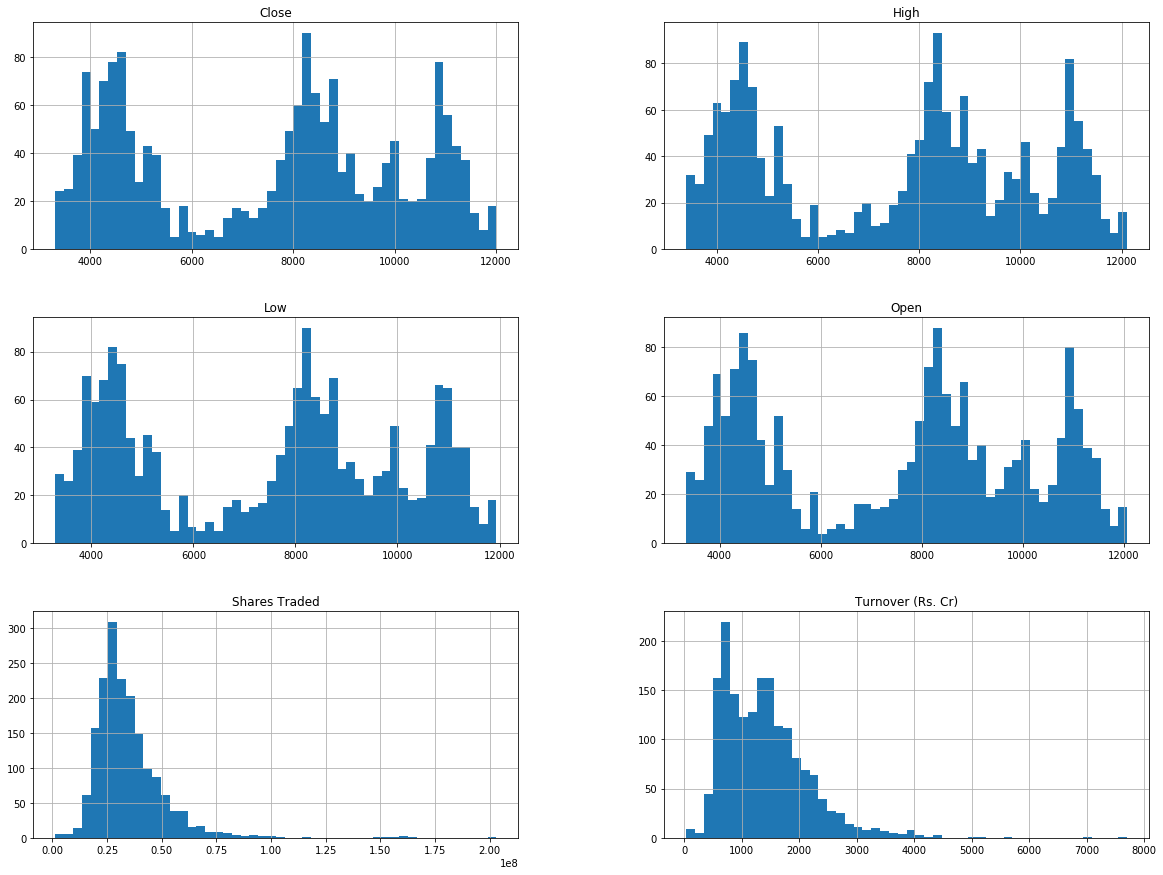

In [101]:
# Data Read 
# Quandl is used to read Open, High , Low .....
quandl.ApiConfig.api_key ="Td2oA_m_SYUdi1X9Htdi" # Please replace with API key can get one from quandl.com
auto = quandl.get("NSE/NIFTY_AUTO")
c_auto = auto.dropna() # Some cleansing ....
c_auto.hist(bins=50, figsize=(20,15))
plt.show()
# Ideally one would do a complete EDA on the data to arrive a complete understanding of relationship between features.


Data pulled from Quandl is an Index for the Automobile companies in India.The 
NIFTY Auto Index is designed to reflect the behaviour and performance of the Indian automobiles sector.The NIFTY Auto Index is computed using free float market capitalization method with a base date of January 1, 2004 indexed to a base value of 1000.



The data for auto has open, high, low , close , share traded and turnover. There are couple of NA entries which have been cleaned.The goal is build a RNN model with LSTM cell to predict prices for auto nifty index. For sake of simplicity the close feature is used later the other features will be included. Before dwelling into the code a quick recap of RNN 
RNN is a type of Neural Network with a self loop in its hidden layer, this enables RNN to use the previous state to learn the current state given the new input. RNN is suited for processing sequential data. LSTM is a specially designed working unit that helps RNN better memorize long term contracts.

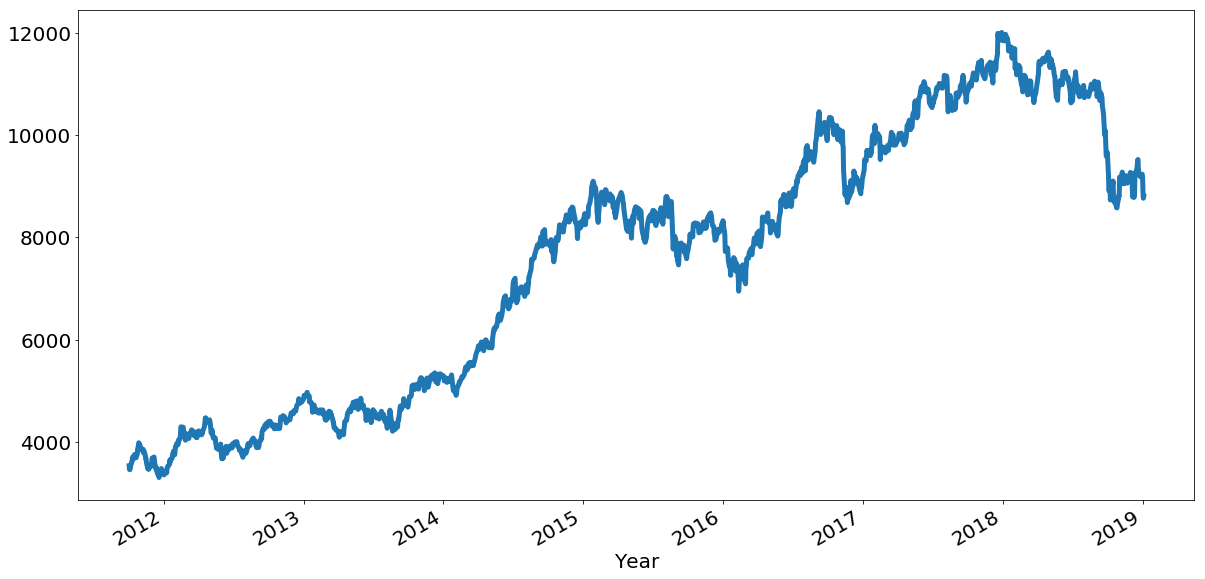

In [109]:
# Some more plot
c_auto['Close'].plot(figsize=(20,10), linewidth=5, fontsize=20) # Trying to get a sense how is this index doing
plt.xlabel('Year', fontsize=20);
c_auto.to_csv("auto.csv", sep=',', encoding='utf-8') # Saving for future use 

In [131]:
# Using the close for LSTM to start with 
data = pd.read_csv('auto.csv')
cl = data.Close
cl = cl.values # Convert to Array


In [132]:
# Scaling is a neccessary evil for algo to perform better
scl = MinMaxScaler()
cl = cl.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl


array([[0.02639892],
       [0.01790945],
       [0.01775437],
       ...,
       [0.64306885],
       [0.62752588],
       [0.63235074]])

# Data Preparation
The idea behind LSTM is more around learning from a set of input sequence to predict the right output sequence. Of course with the backpropogation or how far back the algo has to go, to decide or arrive on the output sequence. 
The data is a time series on length N defined as p0, p1.. pN where pi is close of price on day i. Consider we have sliding window of fixed width sized w  and every time we move right by size w so there is no overlap between the data in all sliding windows. In this example we use a 7 day sliding window, under realistic consideration we would use moving or exponential averages of the close here as mentioned earlier for sake of simplicity close has been used.
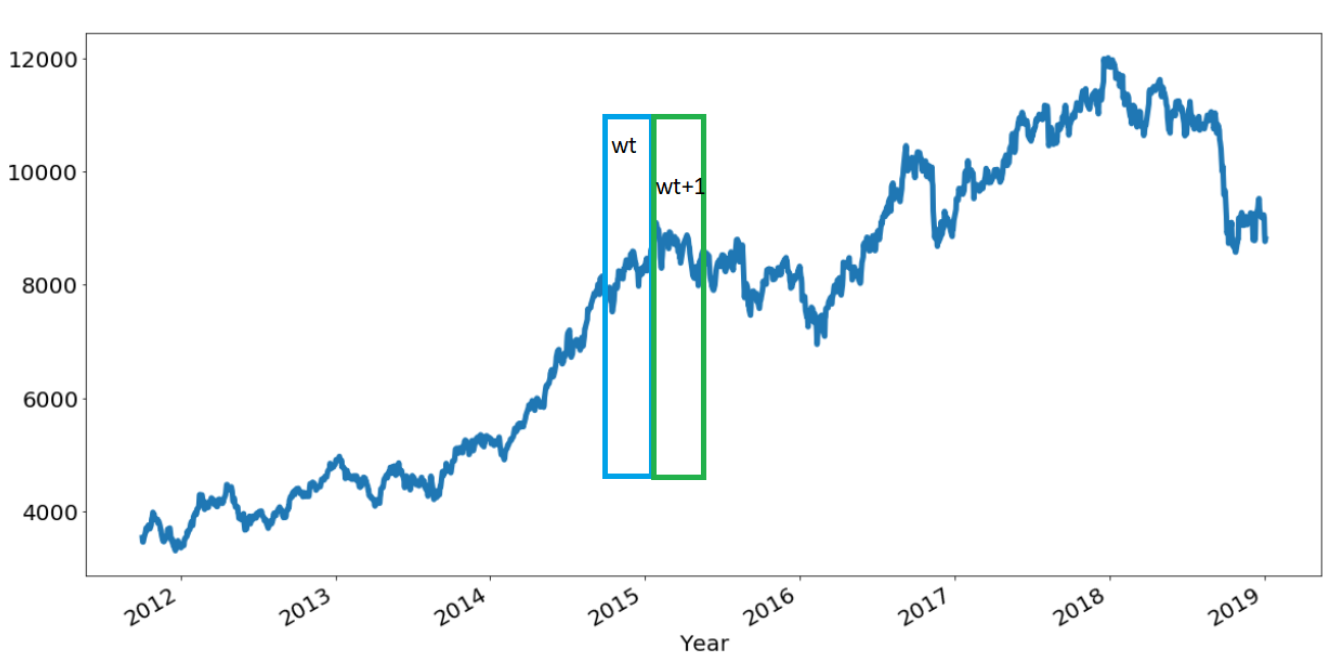

In [113]:
# The key function for building out the data for LSTM consumption.
def BuildData(data, lb):
    X,y =[],[]
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        y.append(data[(i + lb),0])
    return (np.array(X), np.array(y))
X,y = BuildData(cl,15) # 15  days back
X_train, X_test = X [:int(X.shape[0] * 0.8)] , X [int(X.shape[0] * 0.8):]
y_train, y_test = y [:int(y.shape[0] * 0.8)] , y [int(y.shape[0] * 0.8):]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1402, 15), (351, 15), (1402,), (351,))

In [114]:
# LSTM Stacked 2 layers ,with 512 memory cells, 1 Dense to conclude the output.
# Optimizer adam and loss is mse.

model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(15, 1)))
model.add(LSTM(512))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [115]:
# Build test, train set and finally fit into the model
# Note the Model.fit may take a long time depending on the compute and GPU capacity feel free to bring down the memory cells and 
# epochs
# Current configuration took ~ 3 hrs on 32 gb 1 gpu based machine.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
history = model.fit(X_train,y_train, epochs = 300, validation_data = (X_test, y_test),shuffle=False)


Train on 1402 samples, validate on 351 samples
Epoch 1/300
1402/1402 [==============================] - 13s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 2/300
1402/1402 [==============================] - 12s 8ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 3/300
1402/1402 [==============================] - 12s 8ms/step - loss: 0.0055 - val_loss: 0.0146
Epoch 4/300
1402/1402 [==============================] - 12s 9ms/step - loss: 0.0092 - val_loss: 0.0338
Epoch 5/300
1402/1402 [==============================] - 13s 9ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch 6/300
1402/1402 [==============================] - 13s 9ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 7/300
1402/1402 [==============================] - 12s 9ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/300
1402/1402 [==============================] - 13s 9ms/step - loss: 3.2054e-04 - val_loss: 0.0012
Epoch 9/300
1402/1402 [==============================] - 13s 9ms/step - loss: 4.1936e-04 - val_loss: 9.8629e-04
Epoch

1402/1402 [==============================] - 13s 9ms/step - loss: 1.2506e-04 - val_loss: 2.5031e-04
Epoch 75/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.5041e-04 - val_loss: 2.5581e-04
Epoch 76/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.0362e-04 - val_loss: 2.5290e-04
Epoch 77/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.0997e-04 - val_loss: 2.3450e-04
Epoch 78/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.0475e-04 - val_loss: 2.4024e-04
Epoch 79/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.0244e-04 - val_loss: 2.4892e-04
Epoch 80/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.1549e-04 - val_loss: 2.3174e-04
Epoch 81/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.0917e-04 - val_loss: 2.4844e-04
Epoch 82/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.4081e-04 - val_loss: 2.4361e

1402/1402 [==============================] - 13s 9ms/step - loss: 2.8731e-04 - val_loss: 2.2975e-04
Epoch 147/300
1402/1402 [==============================] - 13s 9ms/step - loss: 5.5832e-04 - val_loss: 2.9454e-04
Epoch 148/300
1402/1402 [==============================] - 13s 9ms/step - loss: 6.9999e-04 - val_loss: 5.3539e-04
Epoch 149/300
1402/1402 [==============================] - 13s 9ms/step - loss: 2.7778e-04 - val_loss: 3.1738e-04
Epoch 150/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.4356e-04 - val_loss: 2.2667e-04
Epoch 151/300
1402/1402 [==============================] - 13s 9ms/step - loss: 2.8066e-04 - val_loss: 2.9330e-04
Epoch 152/300
1402/1402 [==============================] - 13s 9ms/step - loss: 4.1081e-04 - val_loss: 2.3147e-04
Epoch 153/300
1402/1402 [==============================] - 13s 9ms/step - loss: 4.5225e-04 - val_loss: 3.1494e-04
Epoch 154/300
1402/1402 [==============================] - 13s 9ms/step - loss: 4.4294e-04 - val_loss:

1402/1402 [==============================] - 13s 9ms/step - loss: 1.7063e-04 - val_loss: 3.2772e-04
Epoch 219/300
1402/1402 [==============================] - 13s 9ms/step - loss: 2.8317e-04 - val_loss: 4.7006e-04
Epoch 220/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.4969e-04 - val_loss: 3.4224e-04
Epoch 221/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.6837e-04 - val_loss: 3.9819e-04
Epoch 222/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.2288e-04 - val_loss: 3.7609e-04
Epoch 223/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.2724e-04 - val_loss: 3.9499e-04
Epoch 224/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.2067e-04 - val_loss: 3.9715e-04
Epoch 225/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.2210e-04 - val_loss: 4.0437e-04
Epoch 226/300
1402/1402 [==============================] - 13s 9ms/step - loss: 1.2144e-04 - val_loss:

1402/1402 [==============================] - 13s 9ms/step - loss: 1.7974e-04 - val_loss: 4.3881e-04
Epoch 291/300
1402/1402 [==============================] - 13s 10ms/step - loss: 2.0476e-04 - val_loss: 4.5593e-04
Epoch 292/300
1402/1402 [==============================] - 14s 10ms/step - loss: 2.5085e-04 - val_loss: 4.9149e-04
Epoch 293/300
1402/1402 [==============================] - 13s 9ms/step - loss: 3.3943e-04 - val_loss: 5.7516e-04
Epoch 294/300
1402/1402 [==============================] - 13s 9ms/step - loss: 4.9847e-04 - val_loss: 7.9046e-04
Epoch 295/300
1402/1402 [==============================] - 13s 9ms/step - loss: 6.9307e-04 - val_loss: 0.0013
Epoch 296/300
1402/1402 [==============================] - 13s 9ms/step - loss: 6.7270e-04 - val_loss: 0.0016
Epoch 297/300
1402/1402 [==============================] - 13s 10ms/step - loss: 3.2469e-04 - val_loss: 7.9625e-04
Epoch 298/300
1402/1402 [==============================] - 13s 10ms/step - loss: 1.9693e-04 - val_loss: 3.2

In [116]:
X_test[0]

array([[0.87985502],
       [0.87369183],
       [0.87312318],
       [0.86555848],
       [0.86898184],
       [0.87175039],
       [0.87260049],
       [0.86511046],
       [0.86341601],
       [0.8423589 ],
       [0.83532263],
       [0.8360636 ],
       [0.83439787],
       [0.83119278],
       [0.84735609]])

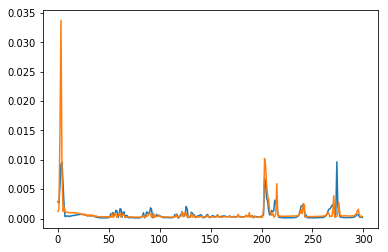

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

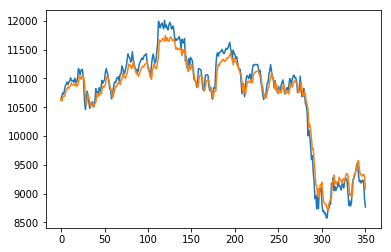

In [142]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))
# The predicted is quite in line with actual. The thing one can ascertain from this curve in the later part is that the index is 
# trending downwards...

In [147]:
# To get an idea of a specific predicted value
act = []
pred = []
i=350
Xt = model.predict(X_test[i].reshape(1,15,1))
print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
pred.append(scl.inverse_transform(Xt))
act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))
# We see there is a difference however when we move into multiple features including trend indicators the gap reduces considerably


predicted:[[9081.99]], actual:[[8767.35]]


In [148]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

In [149]:
result_df

,pred,act
0,9081.990234,8767.35
